**Jigsaw Rate Severity of Toxic Comments**

Raquel Alcaraz

Lucie Bertiere

# Libraries

In [1]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import re
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import Sequential
from keras import layers

# Importing the data

In [2]:
# We import the two datasets
comments_to_score = pd.read_csv("/kaggle/input/jigsaw-toxic-severity-rating/comments_to_score.csv")
train = pd.read_csv("/kaggle/input/jigsaw-toxic-severity-rating/validation_data.csv")

In [3]:
comments_to_score.head(5)

,comment_id,text
0,114890,"""\n \n\nGjalexei, you asked about whether ther..."
1,732895,"Looks like be have an abuser , can you please ..."
2,1139051,I confess to having complete (and apparently b...
3,1434512,"""\n\nFreud's ideas are certainly much discusse..."
4,2084821,It is not just you. This is a laundry list of ...


In [4]:
train.head(5)

,worker,less_toxic,more_toxic
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu..."
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist"


# Cleaning the data

## Function

In [5]:
# We set the stop words in english (the words that we don't want in the clean text
# that are the most used and not really relevant)
stop_words = set(stopwords.words('english'))
# and also the lemmatizer (rocks becomes rock...)
lem = WordNetLemmatizer()


def cleaning_text(text):
    
    # to put everything in lower case (I becomes i)
    text = text.lower()

    # to remove urls
    url = re.compile(r'https?://\S+|www\.\S+')
    text = url.sub(r' ', text)

    # to remove html tags
    html = re.compile(r'<.*?>')
    text = html.sub(r' ', text)
    
    # to remove digits
    text = re.sub(r'\d+',' ', text)
    
    # to remove hashtags
    text = re.sub(r'#\w+',' ', text)
    
    # to remove mentions
    text = re.sub(r'@\w+',' ', text)

    # to remove punctations
    text = re.sub(r"[^\w\s\d]",' ', text)

    # to remove extra white space
    text = re.sub(r"\s+",' ',text).strip()
    
    # removing stop words
    token = word_tokenize(text)
    text=[word for word in token if not word in stop_words]

    # lemmatize
    text = " ".join([lem.lemmatize(t) for t in text])

    return  text
  

## Comments to score

In [6]:
comments_to_score['clean_text'] = comments_to_score['text'].apply(cleaning_text)

In [7]:
comments_to_score.head(5)

,comment_id,text,clean_text
0,114890,"""\n \n\nGjalexei, you asked about whether ther...",gjalexei asked whether anti editorializing pol...
1,732895,"Looks like be have an abuser , can you please ...",look like abuser please look thanks
2,1139051,I confess to having complete (and apparently b...,confess complete apparently blissful ignorance...
3,1434512,"""\n\nFreud's ideas are certainly much discusse...",freud idea certainly much discussed today woul...
4,2084821,It is not just you. This is a laundry list of ...,laundry list stupid allegation scooped god kno...


# Descriptive statistics

TO DO :
- wordcloud toxic comments
- wordcloud less toxic comments

# Functions for the models

In [8]:
# Functions seen in the deep learning course
def plot_history(hist):
    plt.plot(hist.history['loss'], label='train')
    plt.plot(hist.history['val_loss'], label='val')
    plt.legend()
    plt.ylim((0,1))
    plt.title('Loss evolution')
    plt.show()
    plt.plot(hist.history['accuracy'], label='train')
    plt.plot(hist.history['val_accuracy'], label='val')
    plt.legend()
    plt.ylim((0,1))
    plt.title('Accuracy evolution')
    plt.show()

# Idea 1 

See how many times a comment has been labeled toxic or non-toxic.


TO DO :
- Mettre un 0 pour les less toxics
- Mettre un 1 pour les plus toxics
- Concaténer
- Faire une moyenne du commentaire (le score)
- Entraîner le modèle

## Train dataset

### Putting all the comments to a same column

**Less toxic data**

In [9]:
# creating a dataframe with only the less toxic comments
less_toxic_data = train.drop(columns = ['more_toxic'])
# Renaming the column to be able to concatenate afterwards
less_toxic_data = less_toxic_data.rename(columns={"less_toxic": "text"})
# Adding a 0's toxicity column to say that this comment is less toxic for the worker
less_toxic_data['toxicity'] = 0

In [10]:
less_toxic_data.head(5)

,worker,text,toxicity
0,313,This article sucks \n\nwoo woo wooooooo,0
1,188,"""And yes, people should recognize that but the...",0
2,82,"Western Media?\n\nYup, because every crime in...",0
3,347,And you removed it! You numbskull! I don't car...,0
4,539,smelly vagina \n\nBluerasberry why don't you ...,0


**More toxic data**

In [11]:
# creating a dataframe with only the more toxic comments
more_toxic_data = train.drop(columns = ['less_toxic'])
# Renaming the column to be able to concatenate afterwards
more_toxic_data = more_toxic_data.rename(columns={"more_toxic": "text"})
# Adding a 1's toxicity column to say that this comment is more toxic for the worker
more_toxic_data['toxicity'] = 1

In [12]:
more_toxic_data.head(5)

,worker,text,toxicity
0,313,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...,1
1,188,Daphne Guinness \n\nTop of the mornin' my fav...,1
2,82,"""Atom you don't believe actual photos of mastu...",1
3,347,You seem to have sand in your vagina.\n\nMight...,1
4,539,"hey \n\nway to support nazis, you racist",1


**Concatenate**

In [13]:
# The final shape we should have
more_toxic_data.shape[0]+less_toxic_data.shape[0]

60216

In [14]:
# The concatenation
workers_comments = pd.concat([less_toxic_data, more_toxic_data], axis=0)
workers_comments.head(5)

,worker,text,toxicity
0,313,This article sucks \n\nwoo woo wooooooo,0
1,188,"""And yes, people should recognize that but the...",0
2,82,"Western Media?\n\nYup, because every crime in...",0
3,347,And you removed it! You numbskull! I don't car...,0
4,539,smelly vagina \n\nBluerasberry why don't you ...,0


In [15]:
# Checking the shape
workers_comments.shape[0]

60216

### Aggregation by comment

In [16]:
# Aggregate the comments together and take the mean for the toxicity
aggregated_comments = workers_comments.groupby('text').aggregate({'toxicity': 'mean'}).reset_index()
aggregated_comments.head(5)

,text,toxicity
0,\n\nThe comment directly above this one are fr...,0.666667
1,\n\nwhy should people have to read crap posted...,0.888889
2,\nGo F yourself you cottonheadednittymuggins.,0.666667
3,"\nU POUR ADMIN, U UPDATE VANDAL COUNT, WHILE R...",0.000000
4,\n\n koreans claim \n\ni see youve seen the ...,0.333333


In [17]:
# In total we have 14521 comments
aggregated_comments.shape

(14251, 2)

In [18]:
# In total we have 39 degrees of toxicity
np.unique(aggregated_comments['toxicity'])

array([0.        , 0.08333333, 0.1       , 0.11111111, 0.13333333,
       0.14285714, 0.16666667, 0.2       , 0.22222222, 0.25      ,
       0.26666667, 0.27777778, 0.28571429, 0.33333333, 0.38888889,
       0.4       , 0.41666667, 0.42857143, 0.44444444, 0.46153846,
       0.46666667, 0.5       , 0.53333333, 0.55555556, 0.57142857,
       0.58333333, 0.6       , 0.66666667, 0.71428571, 0.73333333,
       0.75      , 0.77777778, 0.8       , 0.83333333, 0.85714286,
       0.88888889, 0.91666667, 0.93333333, 1.        ])

In [19]:
# Let's count how many comments have a level smaller than 50% of toxicity
less_50 = aggregated_comments[aggregated_comments.toxicity<0.5]
less_50.shape

(6786, 2)

In [20]:
# Let's count how many comments have a level greater than 50% of toxicity
more_50 = aggregated_comments[aggregated_comments.toxicity>=0.5]
more_50.shape

# It is pretty balanced

(7465, 2)

In [21]:
# Let's create two classes :
aggregated_comments['score'] = np.where(aggregated_comments.toxicity<0.5, 0, 1)
aggregated_comments.head(5)

,text,toxicity,score
0,\n\nThe comment directly above this one are fr...,0.666667,1
1,\n\nwhy should people have to read crap posted...,0.888889,1
2,\nGo F yourself you cottonheadednittymuggins.,0.666667,1
3,"\nU POUR ADMIN, U UPDATE VANDAL COUNT, WHILE R...",0.000000,0
4,\n\n koreans claim \n\ni see youve seen the ...,0.333333,0


### Cleaning the data

In [22]:
aggregated_comments['clean_text'] = aggregated_comments['text'].apply(cleaning_text)
aggregated_comments.head(5)

,text,toxicity,score,clean_text
0,\n\nThe comment directly above this one are fr...,0.666667,1,comment directly one strange detractor mine cp...
1,\n\nwhy should people have to read crap posted...,0.888889,1,people read crap posted idiot like
2,\nGo F yourself you cottonheadednittymuggins.,0.666667,1,go f cottonheadednittymuggins
3,"\nU POUR ADMIN, U UPDATE VANDAL COUNT, WHILE R...",0.000000,0,u pour admin u update vandal count real admin ...
4,\n\n koreans claim \n\ni see youve seen the ...,0.333333,0,korean claim see youve seen crap claim also


## Training on the train dataset

**Some preparation**

In [23]:
# splitting the dataframe
# Here we split validation data to optimize classifier during training. 
X_train, X_test, y_train, y_test = train_test_split(aggregated_comments['clean_text'], aggregated_comments['score'], 
                                                          test_size=0.2, random_state=1)

In [24]:
X_train = pd.DataFrame(data=X_train)
X_test = pd.DataFrame(data=X_test)

In [25]:
tokenizer = Tokenizer()
# We fit it to the train test
tokenizer.fit_on_texts(X_train['clean_text'])

In [26]:
vocab_length = len(tokenizer.word_index) +1

In [27]:
# we create a list of words encoded
X_train = tokenizer.texts_to_sequences(X_train["clean_text"])
X_test = tokenizer.texts_to_sequences(X_test["clean_text"])

In [28]:
# We need all the list to be of the same length 

# we then  compute the maximum length
max_word_train = 0
max_word_test = 0

for text in X_train:
    length = len(text)
    if length > max_word_train:
        max_word_train = length

for text in X_test:
    length = len(text)
    if length > max_word_test:
        max_word_test= length

max_word = max(max_word_test,max_word_train)
print("Maximum number of words in one tweet: ", max_word)

Maximum number of words in one tweet:  1001


In [29]:
# We then pad the sequences with 1001 as a length
X_train = pad_sequences(X_train, maxlen=max_word, padding='post')
X_test = pad_sequences(X_test, maxlen=max_word, padding='post')

**Building the model**

In [30]:
model_LSTM = Sequential()
model_LSTM.add(layers.Embedding(vocab_length, output_dim=32, input_length=max_word, mask_zero=True))
model_LSTM.add(layers.LSTM(100))
model_LSTM.add(layers.Dense(64, activation="relu"))
model_LSTM.add(layers.Dense(32, activation="relu"))
model_LSTM.add(layers.Dense(16, activation="relu"))
model_LSTM.add(layers.Dense(1, activation='sigmoid'))
model_LSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_LSTM.summary())


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1001, 32)          1052256   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dense (Dense)                (None, 64)                6464      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 1,114,545
Trainable params: 1,114,545
Non-trainable params: 0
______________________________________________

In [31]:
history = model_LSTM.fit(np.array(X_train),
                         np.array(y_train),
                         validation_data=(np.array(X_test), np.array(y_test)),
                         epochs=2,
                         batch_size=128)

2021-12-22 10:03:10.531859: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2
90/90 [==============================] - 204s 2s/step - loss: 0.6639 - accuracy: 0.5738 - val_loss: 0.6419 - val_accuracy: 0.6173
Epoch 2/2
90/90 [==============================] - 199s 2s/step - loss: 0.5425 - accuracy: 0.7341 - val_loss: 0.6631 - val_accuracy: 0.6149


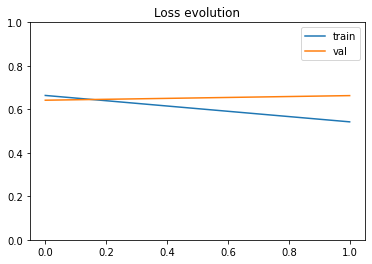

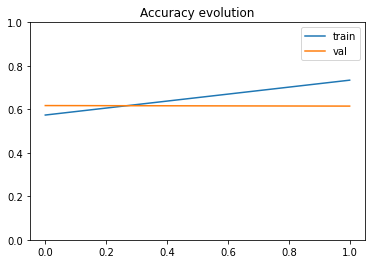

In [32]:
# to see if we have overfitting
plot_history(history)

**Prediction**

In [33]:
to_predict = tokenizer.texts_to_sequences(comments_to_score["clean_text"])
to_predict = pad_sequences(to_predict, maxlen=max_word, padding='post')

pred = model_LSTM.predict(to_predict)

In [34]:
pred

array([[0.21073472],
       [0.24994424],
       [0.2948797 ],
       ...,
       [0.32783163],
       [0.60205036],
       [0.38095647]], dtype=float32)

**Submission file**

In [35]:
# Exporting the submission file
results = pd.DataFrame(comments_to_score["comment_id"])
results["score"] = pred

In [36]:
results.head(5)

,comment_id,score
0,114890,0.210735
1,732895,0.249944
2,1139051,0.294880
3,1434512,0.135814
4,2084821,0.678153


In [37]:
results.to_csv("submission.csv", index=False)